In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier ,BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.metrics import classification_report
%matplotlib inline

In [3]:
#reading img 
pic = cv2.imread("4.jpg")
pic.shape

(330, 213, 3)

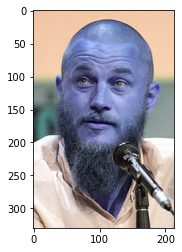

In [4]:
#showing img 
# note : img is in BGR mode 
plt.imshow(pic)

In [4]:
#converting colored img to grayscale
gray = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
gray.shape

(330, 213)

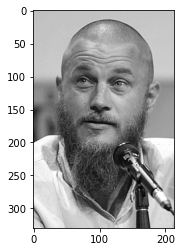

In [5]:
plt.imshow(gray,cmap='gray')

In [6]:
#instantiate Haar Cascade for face and eye detection
face_cascade = cv2.CascadeClassifier('./haar/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./haar/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 20,  45, 166, 166]], dtype=int32)

In [7]:
(x,y,w,h) = faces[0]
x,y,w,h

(20, 45, 166, 166)

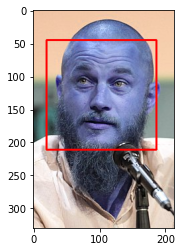

In [8]:
#drwaing rectangle around face
face_img = cv2.rectangle(pic,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img);

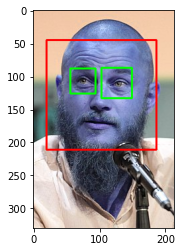

In [9]:
cv2.destroyAllWindows()
#drawing boundries around detected eyes and faces 
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(pic,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

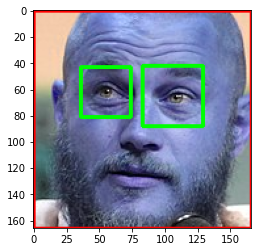

In [10]:
plt.imshow(roi_color,cmap='gray')

In [11]:
from skimage import io
#this function returns detected faces if and only if 2 eyes or more are detected
def get_cropped_image_if_2_eyes(image_path):
    img = io.imread(image_path)
    if len(img.shape)==3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,w,h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) >= 2:
                return roi_color

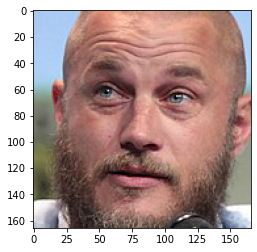

In [12]:
trail = get_cropped_image_if_2_eyes("./test/4.jpg")
plt.imshow(trail)

In [13]:
cropped_img = np.array(roi_color)
cropped_img.shape

(166, 166, 3)

In [14]:
import numpy as np
import pywt
import cv2    
# this function preforms wavelet transformation on images for feature extraction
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

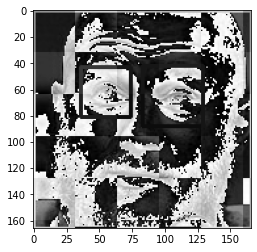

In [15]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

In [16]:
path_to_data = 'Img_data/'
path_to_cropped = 'Img_data/cropped/'

In [17]:
import os
img_dirs=[]
#scanning scrapped images directories 
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [18]:
img_dirs

['Img_data/cropped',
 'Img_data/elon musk',
 'Img_data/jeff bezos',
 'Img_data/mark zuckerberg',
 'Img_data/vladimir putin']

In [19]:
import shutil
#remove cropped file if exists and creates new one
if os.path.exists(path_to_cropped):
     shutil.rmtree(path_to_cropped)
os.mkdir(path_to_cropped)

cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        if ('.jpg') in entry.name:
            try:
                roi_color = get_cropped_image_if_2_eyes(entry.path)
                if roi_color is not None:
                    cropped_folder = path_to_cropped + celebrity_name
                    if not os.path.exists(cropped_folder):
                        os.makedirs(cropped_folder)
                        cropped_image_dirs.append(cropped_folder)
                        print("Generating cropped images in folder: ",cropped_folder)
                    cropped_file_name = celebrity_name + str(count) + ".jpg"
                    cropped_file_path = cropped_folder + "/" + cropped_file_name 
                    cv2.imwrite(cropped_file_path, roi_color)
                    celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
                    count += 1
            except (IOError, SyntaxError) as e:
                print('Bad file:', entry.name)

cropped
elon musk
Generating cropped images in folder:  Img_data/cropped/elon musk
jeff bezos
Generating cropped images in folder:  Img_data/cropped/jeff bezos
mark zuckerberg
Generating cropped images in folder:  Img_data/cropped/mark zuckerberg
vladimir putin
Generating cropped images in folder:  Img_data/cropped/vladimir putin


In [78]:
#creating class dictionary for new cropped images 
celebrity_file_name_dict = {}
for img_dir in cropped_image_dirs:
    celebirty_name = img_dir.split('/')[-1]
    file_list =[]
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
        celebrity_file_name_dict[celebirty_name]=file_list
celebrity_file_name_dict

{'elon musk': ['Img_data/cropped/elon musk\\elon musk1.jpg',
  'Img_data/cropped/elon musk\\elon musk10.jpg',
  'Img_data/cropped/elon musk\\elon musk12.jpg',
  'Img_data/cropped/elon musk\\elon musk13.jpg',
  'Img_data/cropped/elon musk\\elon musk14.jpg',
  'Img_data/cropped/elon musk\\elon musk16.jpg',
  'Img_data/cropped/elon musk\\elon musk17.jpg',
  'Img_data/cropped/elon musk\\elon musk18.jpg',
  'Img_data/cropped/elon musk\\elon musk19.jpg',
  'Img_data/cropped/elon musk\\elon musk2.jpg',
  'Img_data/cropped/elon musk\\elon musk20.jpg',
  'Img_data/cropped/elon musk\\elon musk21.jpg',
  'Img_data/cropped/elon musk\\elon musk22.jpg',
  'Img_data/cropped/elon musk\\elon musk23.jpg',
  'Img_data/cropped/elon musk\\elon musk24.jpg',
  'Img_data/cropped/elon musk\\elon musk25.jpg',
  'Img_data/cropped/elon musk\\elon musk26.jpg',
  'Img_data/cropped/elon musk\\elon musk27.jpg',
  'Img_data/cropped/elon musk\\elon musk28.jpg',
  'Img_data/cropped/elon musk\\elon musk3.jpg',
  'Img_dat

In [21]:
class_dict = {}
count=0
#creatingdictionary for output classes
for celebirty_name in celebrity_file_name_dict.keys():
    class_dict[celebirty_name]=count
    count+=1
class_dict

{'elon musk': 0, 'jeff bezos': 1, 'mark zuckerberg': 2, 'vladimir putin': 3}

In [79]:
X,y = [], []
for celebirty_name , training_samples in celebrity_file_name_dict.items():
    for training_sample in training_samples:
        img = cv2.imread(training_sample)
        resized_sample = cv2.resize(img,(32,32))
        transformed_img = w2d(img)
        transformed_img_rescaled = cv2.resize(transformed_img,(32,32))
        #stacking both the original image and the wavelet transformed image in top of each other
        combined_img = np.vstack((resized_sample.reshape(32*32*3,1),transformed_img_rescaled.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebirty_name])

In [54]:
X[0].shape

(4096,)

In [83]:
#reshaping images
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(271, 4096)

In [84]:
X_train ,X_test , y_train , y_test = train_test_split(X,y,test_size=.3,random_state=0)

In [85]:
pipe = Pipeline([("StandardScaler" , StandardScaler()),("LogisticRegression",LogisticRegression(random_state=0))])
pipe.fit(X_train,y_train)
pipe.score(X_test,y_test)

C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7804878048780488

In [28]:
print(classification_report(y_test,pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.71      0.71      0.71        21
           2       0.79      0.90      0.84        21
           3       0.93      0.89      0.91        28

    accuracy                           0.81        85
   macro avg       0.80      0.79      0.80        85
weighted avg       0.81      0.81      0.81        85



In [30]:
X_test.shape

(85, 4096)

In [31]:
#selecting hyperparameters to tune using gridsearchcv
model_params = {
    'svm': {
        'model': SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [32]:
scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.701282,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,logistic_regression,0.782436,{'logisticregression__C': 1}


In [33]:
for estimator in best_estimators:
    print(estimator + " " +str(best_estimators[estimator].score(X_test,y_test)))
#best_estimators['logistic_regression'].score(X_test,y_test)

svm 0.8235294117647058
logistic_regression 0.8235294117647058


In [34]:
best_clf = best_estimators['logistic_regression']

Text(69.0, 0.5, 'Truth')

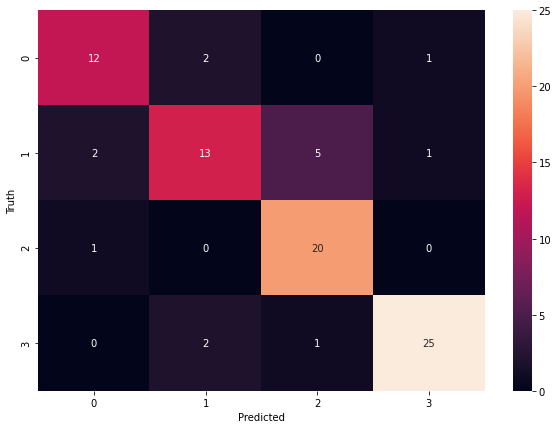

In [35]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [37]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [38]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))